In [1]:
!pip install Sastrawi --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.3 MB/s eta 0:00:00


In [2]:
!pip install transformers
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) 

In [3]:
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device('cuda')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter

import nltk
import re
from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Load Dataset
data = pd.read_csv('600 news with valid hoax label.csv', delimiter=';', encoding='Windows-1254')

# Tampilkan DataFrame dan Jumah kolom dan baris
print(data.shape)
data.head()

(600, 2)


,berita,tagging
0,"Jakarta, Di jejaring sosial, banyak beredar in...",Valid
1,Isu bahwa ikan lele mengandung sel kanker di j...,Valid
2,Bagi penikmat kuliner dengan bahan dasar ikan ...,Valid
3,Ikan lele merupakan salah satu makanan favorit...,Valid
4,Ikan lele merupakan bahan makanan yang cukup p...,Valid


In [5]:
# Menambahkan label berdasarkan tangging 'Valid' menjadi 0 dan 'Hoax' menjadi 1
data['label'] = data['tagging'].apply(lambda x: 0 if x == 'Valid' else 1)

# Tampilkan DataFrame setelah penambahan
data.tail()

,berita,tagging,label
595,Kabar yang beredar seputar rencana kenaikan ga...,Valid,0
596,Kabar yang beredar seputar rencana kenaikan ga...,Valid,0
597,"Akhir-akhir ini, beredar pemberitaan yang meny...",Valid,0
598,Rancangan peraturan pemerintah (RPP) tentang G...,Valid,0
599,Kabar yang beredar seputar rencana kenaikan ga...,Valid,0


# ***EDA***

0    372
1    228
Name: label, dtype: int64


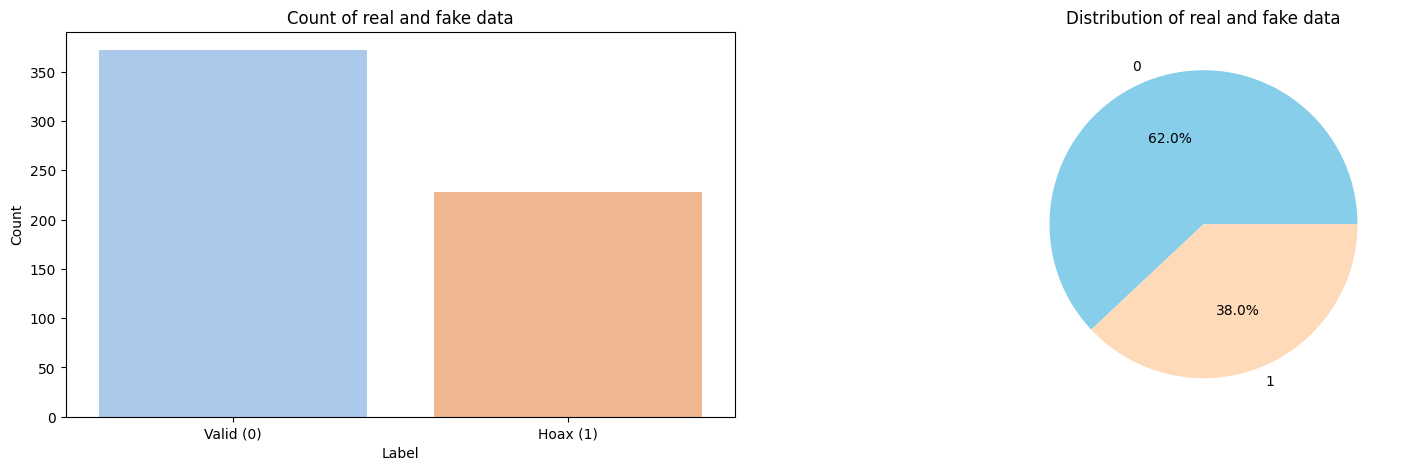

In [6]:
# Menghitung jumlah valid dan hoax
data['label'] = data['label'].astype(int)
print(data["label"].value_counts())

# Menghitung jumlah masing-masing nilai
counts = data['label'].value_counts()

# Membuat subplots
fig, ax = plt.subplots(1, 2, figsize=(19, 5))

# Count plot
g1 = sns.barplot(x=counts.index, y=counts.values, palette="pastel", ax=ax[0])
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Label")
g1.set_xticks([0, 1])
g1.set_xticklabels(['Valid (0)', 'Hoax (1)'])
g1.set_xlim(-0.5, 1.5)

# Piechart
g2 = ax[1].pie(data["label"].value_counts(), explode=[0, 0], labels=data["label"].value_counts().index, autopct='%1.1f%%', colors=['SkyBlue', 'PeachPuff'])
ax[1].set_title("Distribution of real and fake data")

plt.show()

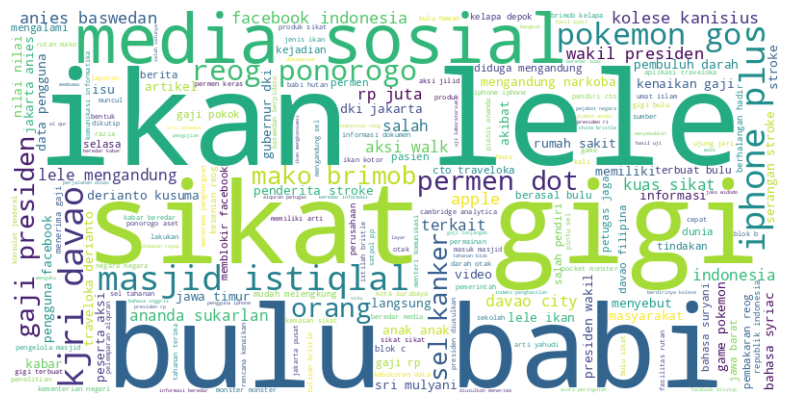

In [7]:
# Wordcloud
data_berita = data['berita']

# Gabungkan semua string dari dataset
joined_text = " ".join(str(word) for word in data_berita)

# Buang tanda baca dan ubah ke lowercase
cleaned_text = "".join(c if c.isalnum() or c.isspace() else " " for c in joined_text)
cleaned_text = cleaned_text.lower()

# Tentukan stopwords dengan standar library Sastrawi
sastrawi_stopword_remover = StopWordRemoverFactory()
sastrawi_stopwords = sastrawi_stopword_remover.get_stop_words()

# Menambahkan stopwords yang menurut kita
personalized_stopwords_file = "stopword_list_tala.txt"
with open(personalized_stopwords_file, "r") as file:
    personalized_stopwords = [line.strip() for line in file]

# Gabungkan stopwords Sastrawi dengan stopwords yang dipersonalisasi
combined_stopwords = set(sastrawi_stopwords).union(personalized_stopwords)

# Hapus stopwords menggunakan daftar stopwords gabungan
cleaned_text_no_stopwords = " ".join(word for word in cleaned_text.split() if word not in combined_stopwords)

# Hapus karakter dan tanda baca non-alfanumerik
cleaned_text_no_special_chars = re.sub(r'[^a-zA-Z\s]', '', cleaned_text_no_stopwords)

# Hapus nilai numerik
cleaned_text_no_numerical = " ".join(word for word in cleaned_text_no_special_chars.split() if not word.isdigit())

# Generate wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cleaned_text_no_numerical)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

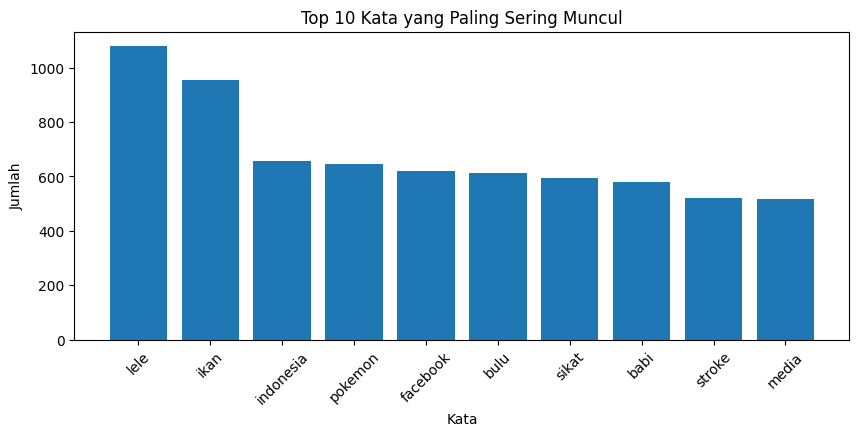

In [8]:
# Tokenize teks tadi untuk mendapatkan kata-kata individual
words = cleaned_text_no_numerical.split()

# Hitung frekuensi setiap kata
word_freq = Counter(words)

# Urutkan kata-kata berdasarkan frekuensinya dalam urutan menurun
sorted_word_freq = word_freq.most_common()

# Pilih 10 kata teratas
top_words = dict(sorted_word_freq[:10])

# Plot
plt.figure(figsize=(10, 4))
plt.bar(top_words.keys(), top_words.values())
plt.xlabel('Kata')
plt.ylabel('Jumlah')
plt.title('Top 10 Kata yang Paling Sering Muncul')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='count', ylabel='word'>

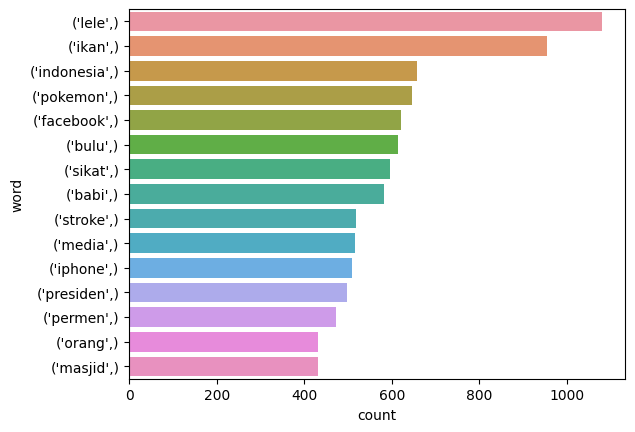

<Figure size 1600x900 with 0 Axes>

In [9]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    fig = sns.barplot(x='count',y='word', data=n_gram_df)
    plt.figure(figsize = (16,9))
    return fig

draw_n_gram(words,1)

# ***Preprocessing***

In [38]:
# Preprocessing
data_berita = data['berita']

# Gabungkan semua string dari dataset
# joined_text = " ".join(str(word) for word in data_berita)

# Buang tanda baca dan ubah ke lowercase
# cleaned_text = "".join(c if c.isalnum() or c.isspace() else " " for c in joined_text)
cleaned_text = data_berita.str.lower()

# Tentukan stopwords dengan standar library Sastrawi
sastrawi_stopword_remover = StopWordRemoverFactory()
sastrawi_stopwords = sastrawi_stopword_remover.get_stop_words()

# Menambahkan stopwords yang menurut kita
personalized_stopwords_file = "stopword_list_tala.txt"
with open(personalized_stopwords_file, "r") as file:
    personalized_stopwords = [line.strip() for line in file]

# Gabungkan stopwords Sastrawi dengan stopwords yang dipersonalisasi
combined_stopwords = set(sastrawi_stopwords).union(personalized_stopwords)

# Remove stopwords using combined list for each line
cleaned_text_no_stopwords = cleaned_text.apply(lambda x: ' '.join(word for word in x.split() if word not in combined_stopwords))

# Remove non-alphanumeric characters
cleaned_text_no_special_chars = cleaned_text_no_stopwords.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Remove numerical values
cleaned_text_no_numerical = cleaned_text_no_special_chars.apply(lambda x: ' '.join(word for word in x.split() if not word.isdigit()))
cleaned_text_no_numerical

0      jakarta jejaring sosial beredar informasi meny...
1      isu ikan lele mengandung sel kanker jejaring s...
2      penikmat kuliner bahan dasar ikan lele berita ...
3      ikan lele salah makanan favorit indonesia harg...
4      ikan lele bahan makanan populer indonesia ini ...
                             ...                        
595    kabar beredar seputar rencana kenaikan gaji pr...
596    kabar beredar seputar rencana kenaikan gaji pr...
597    akhirakhir ini beredar pemberitaan kenaikan ga...
598    rancangan peraturan pemerintah rpp gaji tunjan...
599    kabar beredar seputar rencana kenaikan gaji pr...
Name: berita, Length: 600, dtype: object

# ***BERT Model***

In [10]:
# Load BERT model dan tokenizer  menggunakan via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [39]:
train_text, temp_text, train_labels, temp_labels = train_test_split(cleaned_text_no_numerical, data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['tagging'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [40]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [41]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [42]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [43]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [44]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [46]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10

Evaluating...

Training Loss: 0.681
Validation Loss: 0.662

 Epoch 2 / 10

Evaluating...

Training Loss: 0.664
Validation Loss: 0.663

 Epoch 3 / 10

Evaluating...

Training Loss: 0.666
Validation Loss: 0.663

 Epoch 4 / 10

Evaluating...

Training Loss: 0.662
Validation Loss: 0.663

 Epoch 5 / 10

Evaluating...

Training Loss: 0.671
Validation Loss: 0.663

 Epoch 6 / 10

Evaluating...

Training Loss: 0.675
Validation Loss: 0.664

 Epoch 7 / 10

Evaluating...

Training Loss: 0.666
Validation Loss: 0.665

 Epoch 8 / 10

Evaluating...

Training Loss: 0.659
Validation Loss: 0.664

 Epoch 9 / 10

Evaluating...

Training Loss: 0.661
Validation Loss: 0.664

 Epoch 10 / 10

Evaluating...

Training Loss: 0.663
Validation Loss: 0.664


In [47]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77        56
           1       0.00      0.00      0.00        34

    accuracy                           0.62        90
   macro avg       0.31      0.50      0.38        90
weighted avg       0.39      0.62      0.48        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# # load weights of best model
# path = '/content/drive/MyDrive/c1_fakenews_weights.pt'
# state_dict = torch.load(path)
# if "bert.embeddings.position_ids" in state_dict:
#     del state_dict["bert.embeddings.position_ids"]
# model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>